<a href="https://colab.research.google.com/github/sbollmannMRI/scout2B1/blob/master/Scout2B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup for running on Google Colab
This notebook is built to run completely on google colab so there is no further setup required, except making sure to select a GPU: Click Runtime -> Change runtime type -> GPU


# Setup for Running on your own GPU
This notebook can also run on your own GPU. Either download the notebook file and run directly via jupyter, or you could even connect this Colab notebook to your local GPU:

* from the system where you run the Browser with google colab, open an SSH connection to your GPU server forwarding the jupyter port:

```
ssh -L 8888:127.0.0.1:8888 user@your-GPU-server
```

* make sure that the user on the GPU server has access to the "local_scratch_dir" (e.g. /content)

```
sudo mkdir /content
sudo chown $USER /content
```

* install required packages:

```
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh
bash
conda create -n Scout2B1
conda activate Scout2B1
conda install tensorflow-gpu==1.15
conda install -c conda-forge nibabel
conda install matplotlib
pip install jupyter_http_over_ws
```

* set a fixed token to simplify future connections:

```
vi .jupyter/jupyter_notebook_config.json
```
```
{
  "NotebookApp": {
    "token": "5e14ad478asdg5MRM_ROCKS4sgdg3a7a6f4c50e14",
    "nbserver_extensions": {
      "jupyter_http_over_ws": true
    }
  }
}
```

* start jupyter on your GPU server:

```
jupyter notebook  --ip=0.0.0.0   --NotebookApp.allow_origin='https://colab.research.google.com'   --port=8888   --NotebookApp.port_retries=0
```

* in google colab, click on "Connect to local runtime" and enter the URL including your jupyter token

```
http://localhost:8888/?token=....
```

# Check if GPU is enabled

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Sep 12 05:40:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    37W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


# Connect google drive
Connect our Colab Notebook to Google drive so that you can store the data there. <br>
This will create a folder called "scout2B1" in your google drive to store the results. When executing this notebook on your own computer the data will be stored in /content


In [3]:
import os

try: 
  from google.colab import drive
  google_drive_dir = '/content/drive/My Drive/scout2B1'
  # select where to store the data - a free google account is sufficient to store all data in this example. 
  data_directory = google_drive_dir
  # data_directory = local_scratch_dir
  drive.mount('/content/drive')
except:
  local_scratch_dir = '/content'
  data_directory = local_scratch_dir

if not os.path.isdir(data_directory):
    os.mkdir(data_directory)
os.chdir(data_directory)


# define working directory
work_dir = os.path.join(data_directory,'osfstorage')

# define checkpoint directory
checkpoint_directory = os.path.join(work_dir,'checkpoints')

# disable training when set to False
training_switch=True
# training_switch=False

 # Download Data
 The data for training our model is stored in OSF (https://osf.io/y5cq9/). 
 <br>
 The data will be downladed from OSF to the Disk allocated by the colab on its virtual machine in the path below:
 <br>
/content/data/osfstorage
 <br>
 <br>
 **Scout**: Containing 28 localizer scans
 <br>
 **B1Map**: Containing 28 SA2RAGE B1 map scans of the same group of patients which are already resliced into localizer space and masked. 
 <br>
 **UnseenData**: Containing one pair of scout and B1 map which is not used during the training process. This data will be used for prediction. 
 <br>
 <br>
 The purpose is to use the 28 (scout, B1map) pairs to train a UNet CNN structure so that the network learns how to predict a B1 map from a scout scan. 
 <br>
 In the next step, we will use the trained network on the unseen data to see if the CNN works on data not used for training. 


In [40]:
 # Install the client code of Open Sience Framework (OSF)
 !pip install osfclient

In [5]:
os.chdir(data_directory)
data_directory

'/content'

In [6]:
# Download data from OSF
data_exists = False
print('testing if ',work_dir, ' exists ...')
if os.path.isdir(work_dir):
  for element in os.listdir(work_dir):
    if ('B1Map') in element:
      print('data already exists. To trigger a re-download: Delete ', work_dir)
      data_exists = True
  
if not data_exists:
      print('data does not exist yet ...')
      print('dowloading data to: ',data_directory)
      os.chdir(data_directory)
      !osf -p y5cq9 clone .



testing if  /content/osfstorage  exists ...
data already exists. To trigger a re-download: Delete  /content/osfstorage


In [7]:
#to trigger a redownload:
# !rm -rf /content/drive/My\ Drive/scout2B1/
# !ls /content/drive/My\ Drive/
# !rm -rf /content/osfstorage
# !ls /content

# Import Packages
The packages needed during the project are imported here:

In [8]:
import nibabel as nib
import numpy as np
from datetime import datetime
import os

try:
  # %tensorflow_version only exists in Colab.
  # Tensorflow magic: https://colab.research.google.com/notebooks/tensorflow_version.ipynb#scrollTo=EPV9PFKLVxlR
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.contrib.learn.python.learn import monitors as monitor_lib
from tensorflow.python.ops import array_ops
import matplotlib.pyplot as plt
import nibabel as nib
from matplotlib import transforms
from scipy import ndimage

# Function Definitions
 
There are three types of functions defined here. 
<br>
**Main Functions**: 
<br> 
1. make_data(): This function crops patches from the data and then converts them to tfrecord files that are used during the training. 
2. train_model(): This function trains the model using the training parameters that are set in the **TRAIN_FLAGS** dictionary
3. predict_model(): This function uses the checkpoints created during the training phase and applies the network to new data.  

**Model Architecture**:
<br>
function *conv_arci* is the function where the architecture of the model is defined using keras and tensorflow

**Utility functions**: 
<br> 
These functions do a particular job and help the main functions with their tasks.

## Utility Functions

### Function: convert_to
This functions converts the input data, which is stored as a numpy array to a TFRecords file that can be read by tensorflow

In [9]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert_to(input_data, target_data, state, names, tfpath):
    """    
    :param input_data:
    :param target_data:
    :param state: could be 'training' 'evaluation' etc.
    :param names: the name for the file. Is concatenated with the 'state'
    :return: A TFRecord-file
    """
    num_examples = input_data.shape[0]

    rows = input_data.shape[1]
    cols = input_data.shape[2]
    depth = 1  # gray-scale image has only 1 channel
    filename = os.path.join(tfpath, state + names + '.tfrecord')
    print('Writing', filename)

    if not os.path.exists(os.path.join(tfpath, state)):  # if the path doesnt exist. Make one
        os.makedirs(os.path.join(tfpath, state))

    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
    writer = tf.python_io.TFRecordWriter(filename, options=options)
    for index in range(num_examples):
        if index % 50 == 0:
          print('written ' + str(index) + ' of ' + str(num_examples) + ' examples')
        input_data_string = input_data[index].tostring()
        target_data_string = target_data[index].tostring()
        example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(rows),
            'width': _int64_feature(cols),
            'depth': _int64_feature(depth),
            'target_data_img': _bytes_feature(target_data_string),
            'input_data_img': _bytes_feature(input_data_string)}))
        writer.write(example.SerializeToString())
    print('success. Wrote ', filename)
    writer.close()


### Function: cut_one_example
This function creates patches with predefined size from the input images

In [10]:
def cut_one_example(p_dim, i, data_target, data_input):
    """   
    :param p_dim:
    :return: one example of simulation data
    """
    np.random.seed()  # re-seed - important when running in parallel-mode.

    if len(data_target.shape) == 4:
        brainX, brainY, brainZ, t = data_target.shape

    if len(data_target.shape) == 3:
        brainX, brainY, brainZ = data_target.shape

    randomX = np.random.randint(0, brainX - p_dim)
    randomY = np.random.randint(0, brainY - p_dim)
    randomZ = np.random.randint(0, brainZ - p_dim)

    data_target_patch = data_target[randomX:randomX + p_dim, randomY:randomY + p_dim, randomZ:randomZ + p_dim]
    data_input_patch = data_input[randomX:randomX + p_dim, randomY:randomY + p_dim, randomZ:randomZ + p_dim]
    
    return data_target_patch, data_input_patch

### Function: generate_file_list
This function generates a list of the filenames and the paths in 'filepath'

In [11]:
def generate_file_list(file_path, p_shape):
    """
    :param file_path: the path to the folder where the files of interest resides
    :param p_shape:
    :return: a list where the filenames and filepaths have been joined
    """
    filenames = os.listdir(file_path)

    for index, item in enumerate(filenames):
        if item.__contains__('size' + str(p_shape[0])):
            filenames[index] = file_path + item
        else:
            raise FileNotFoundError('you have files in the folder that does not match the shapes')

    return filenames


### Function: data_input_fn

In [12]:
def data_input_fn(filenames, p_shape, batch=None, nepochs=None, shuffle=True):
    def _parser(record):
        features = {
            'input_data_img': tf.FixedLenFeature([], tf.string, default_value=""),
            'target_data_img': tf.FixedLenFeature([], tf.string, default_value="")
        }
        parsed_record = tf.parse_single_example(record, features)
        forward_image = tf.decode_raw(parsed_record['input_data_img'], tf.float32)
        forward_image = tf.reshape(forward_image, [p_shape[0], p_shape[1], p_shape[2], 1])

        target_data = tf.decode_raw(parsed_record['target_data_img'], tf.float32)
        target_data = tf.reshape(target_data, [p_shape[0], p_shape[1], p_shape[2], 1])

        return {"x": forward_image}, target_data

    def _input_fn():

        dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP').map(_parser)
        if shuffle:
            dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.repeat(nepochs)
        dataset = dataset.batch(batch)

        iterator = dataset.make_one_shot_iterator()
        features, labels = iterator.get_next()

        return features, labels

    return _input_fn


## Model Architecture

### Function: conv_arci
This function creates a model with UNet architcture

In [13]:
def conv_arci(features, labels, mode, params):
  
  print(params['type_arci'] + ' has been chosen')

  xdim, ydim, zdim = params['shape']
  filter_scale = params['filter_downscale_factor']
  dropout_rate = params['dropout_rate']
  input_shape = array_ops.shape(features["x"])
       
  if params['type_arci'] == 'UnetResidual1x1':
    conv1 = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                       activation='relu',
                                       padding='same', name='conv1', kernel_initializer='he_normal')(features["x"])
    drop1 = tf.layers.dropout(inputs=conv1, rate=dropout_rate, training=mode == tf.estimator.ModeKeys.TRAIN,
                              noise_shape=(input_shape[0], 1, 1, 1, input_shape[4]))
    conv1_1 = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv2', kernel_initializer='he_normal')(drop1)
    drop2 = tf.layers.dropout(inputs=conv1_1, rate=dropout_rate, training=mode == tf.estimator.ModeKeys.TRAIN,
                              noise_shape=(input_shape[0], 1, 1, 1, input_shape[4]))
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), name='pool1')(drop2)

    conv2 = tf.keras.layers.Conv3D(int(128 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv3', kernel_initializer='he_normal')(pool1)
    drop3 = tf.layers.dropout(inputs=conv2, rate=dropout_rate, training=mode == tf.estimator.ModeKeys.TRAIN,
                              noise_shape=(input_shape[0], 1, 1, 1, input_shape[4]))
    conv2_1 = tf.keras.layers.Conv3D(int(128 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv4', kernel_initializer='he_normal')(drop3)
    drop4 = tf.layers.dropout(inputs=conv2_1, rate=dropout_rate, training=mode == tf.estimator.ModeKeys.TRAIN,
                              noise_shape=(input_shape[0], 1, 1, 1, input_shape[4]))
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), name='pool2')(drop4)

    conv3 = tf.keras.layers.Conv3D(int(256 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv5', kernel_initializer='he_normal')(pool2)
    drop5 = tf.layers.dropout(inputs=conv3, rate=dropout_rate, training=mode == tf.estimator.ModeKeys.TRAIN,
                              noise_shape=(input_shape[0], 1, 1, 1, input_shape[4]))
    conv3_1 = tf.keras.layers.Conv3D(int(256 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv6', kernel_initializer='he_normal')(drop5)
    drop6 = tf.layers.dropout(inputs=conv3_1, rate=dropout_rate, training=mode == tf.estimator.ModeKeys.TRAIN,
                              noise_shape=(input_shape[0], 1, 1, 1, input_shape[4]))
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), name='pool3')(drop6)

    conv4 = tf.keras.layers.Conv3D(int(512 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv7', kernel_initializer='he_normal')(pool3)
    drop7 = tf.layers.dropout(inputs=conv4, rate=dropout_rate, training=mode == tf.estimator.ModeKeys.TRAIN,
                              noise_shape=(input_shape[0], 1, 1, 1, input_shape[4]))
    conv4_1 = tf.keras.layers.Conv3D(int(512 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv8', kernel_initializer='he_normal')(drop7)
    drop8 = tf.layers.dropout(inputs=conv4_1, rate=dropout_rate, training=mode == tf.estimator.ModeKeys.TRAIN,
                              noise_shape=(input_shape[0], 1, 1, 1, input_shape[4]))
    pool4 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), name='pool4')(drop8)

    conv5 = tf.keras.layers.Conv3D(int(1024 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv9', kernel_initializer='he_normal')(pool4)
    drop9 = tf.layers.dropout(inputs=conv5, rate=dropout_rate, training=mode == tf.estimator.ModeKeys.TRAIN,
                              noise_shape=(input_shape[0], 1, 1, 1, input_shape[4]))
    conv5_1 = tf.keras.layers.Conv3D(int(1024 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv10', kernel_initializer='he_normal')(drop9)
    drop10 = tf.layers.dropout(inputs=conv5_1, rate=dropout_rate, training=mode == tf.estimator.ModeKeys.TRAIN,
                                noise_shape=(input_shape[0], 1, 1, 1, input_shape[4]))

    up6 = tf.concat(
        [tf.keras.layers.Conv3DTranspose(int(512 / filter_scale), (2, 2, 2), strides=(2, 2, 2), padding='same',
                                          activation='relu', name='up_conv1', kernel_initializer='he_normal')(
            drop10), conv4_1],
        axis=-1)
    conv6 = tf.keras.layers.Conv3D(int(512 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv11', kernel_initializer='he_normal')(up6)
    conv6 = tf.keras.layers.Conv3D(int(512 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv12', kernel_initializer='he_normal')(conv6)

    up7 = tf.concat(
        [tf.keras.layers.Conv3DTranspose(int(256 / filter_scale), (2, 2, 2), strides=(2, 2, 2), padding='same',
                                          activation='relu', name='up_conv2', kernel_initializer='he_normal')(
            conv6), conv3_1], axis=-1)
    conv7 = tf.keras.layers.Conv3D(int(256 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv13', kernel_initializer='he_normal')(up7)
    conv7 = tf.keras.layers.Conv3D(int(256 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv14', kernel_initializer='he_normal')(conv7)

    up8 = tf.concat(
        [tf.keras.layers.Conv3DTranspose(int(128 / filter_scale), (2, 2, 2), strides=(2, 2, 2), padding='same',
                                          activation='relu', name='up_conv3', kernel_initializer='he_normal')(
            conv7), conv2_1], axis=-1)
    conv8 = tf.keras.layers.Conv3D(int(128 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv15', kernel_initializer='he_normal')(up8)
    conv8 = tf.keras.layers.Conv3D(int(128 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv16', kernel_initializer='he_normal')(conv8)

    up9 = tf.concat(
        [tf.keras.layers.Conv3DTranspose(int(64 / filter_scale), (2, 2, 2), strides=(2, 2, 2), padding='same',
                                          activation='relu', name='up_conv4', kernel_initializer='he_normal')(
            conv8), conv1_1], axis=-1)
    conv9 = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv17', kernel_initializer='he_normal')(up9)
    conv9 = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                    activation='relu',
                                    padding='same', name='conv18', kernel_initializer='he_normal')(conv9)

    adaptation_layer_1 = tf.keras.layers.Conv3D(kernel_size=1, filters=128, strides=(1, 1, 1), name='output_layer',
                                          kernel_initializer='he_normal', activation=None)(conv9)

    adaptation_layer_2 = tf.keras.layers.Conv3D(kernel_size=1, filters=64, strides=(1, 1, 1), name='output_layer',
                                          kernel_initializer='he_normal', activation=None)(adaptation_layer_1)

    output_layer = tf.keras.layers.Conv3D(kernel_size=1, filters=1, strides=(1, 1, 1), name='output_layer',
                                          kernel_initializer='he_normal', activation=None)(adaptation_layer_2 )

    output_layer = tf.add(output_layer, features['x'])
    
  
  if params['type_arci'] == 'UnetResidual1x1SimplerConvPool':
      conv1_down = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv1_down', kernel_initializer='he_normal')(features["x"])

      pool1 = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(2, 2, 2),
                                        activation='relu',
                                        padding='same', name='pool1', kernel_initializer='he_normal')(conv1_down)

      conv2_down = tf.keras.layers.Conv3D(int(128 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv2_down', kernel_initializer='he_normal')(pool1)


      pool2 = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(2, 2, 2),
                                        activation='relu',
                                        padding='same', name='pool2', kernel_initializer='he_normal')(conv2_down)

      conv3_down = tf.keras.layers.Conv3D(int(256 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv3_down', kernel_initializer='he_normal')(pool2)

      pool3 = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(2, 2, 2),
                                        activation='relu',
                                        padding='same', name='pool3', kernel_initializer='he_normal')(conv3_down)
      
      conv3_up = tf.keras.layers.Conv3D(int(512 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv3_up', kernel_initializer='he_normal')(pool3)

      up3 = tf.concat(
          [tf.keras.layers.Conv3DTranspose(int(256 / filter_scale), (2, 2, 2), strides=(2, 2, 2), padding='same',
                                            activation='relu', name='up3', kernel_initializer='he_normal')(
              conv3_up), conv3_down], axis=-1)
      conv2_up = tf.keras.layers.Conv3D(int(256 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv2_up', kernel_initializer='he_normal')(up3)

      up2 = tf.concat(
          [tf.keras.layers.Conv3DTranspose(int(128 / filter_scale), (2, 2, 2), strides=(2, 2, 2), padding='same',
                                            activation='relu', name='up_conv3', kernel_initializer='he_normal')(
              conv2_up), conv2_down], axis=-1)
      conv1_up = tf.keras.layers.Conv3D(int(128 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv1_up', kernel_initializer='he_normal')(up2)
      
      
      up1 = tf.concat(
          [tf.keras.layers.Conv3DTranspose(int(64 / filter_scale), (2, 2, 2), strides=(2, 2, 2), padding='same',
                                            activation='relu', name='up_conv4_down', kernel_initializer='he_normal')(
              conv1_up), conv1_down], axis=-1)
      conv0_up = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv0_up', kernel_initializer='he_normal')(up1)
      

      adaptation_layer_1 = tf.keras.layers.Conv3D(kernel_size=1, filters=128, strides=(1, 1, 1), name='output_layer',
                                            kernel_initializer='he_normal', activation=None)(conv0_up)

      adaptation_layer_2 = tf.keras.layers.Conv3D(kernel_size=1, filters=64, strides=(1, 1, 1), name='output_layer',
                                            kernel_initializer='he_normal', activation=None)(adaptation_layer_1)

      output_layer = tf.keras.layers.Conv3D(kernel_size=1, filters=1, strides=(1, 1, 1), name='output_layer',
                                            kernel_initializer='he_normal', activation=None)(adaptation_layer_2 )

      output_layer = tf.add(output_layer, features['x'])
  
  if params['type_arci'] == 'UnetResidualSimplerConvPool':
      conv1_down = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv1_down', kernel_initializer='he_normal')(features["x"])

      pool1 = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(2, 2, 2),
                                        activation='relu',
                                        padding='same', name='pool1', kernel_initializer='he_normal')(conv1_down)

      conv2_down = tf.keras.layers.Conv3D(int(128 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv2_down', kernel_initializer='he_normal')(pool1)


      pool2 = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(2, 2, 2),
                                        activation='relu',
                                        padding='same', name='pool2', kernel_initializer='he_normal')(conv2_down)

      conv3_down = tf.keras.layers.Conv3D(int(256 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv3_down', kernel_initializer='he_normal')(pool2)

      


      pool3 = tf.keras.layers.Conv3D(int(64 / filter_scale), kernel_size=(3, 3, 3), strides=(2, 2, 2),
                                        activation='relu',
                                        padding='same', name='pool3', kernel_initializer='he_normal')(conv3_down)
      
      conv3_up = tf.keras.layers.Conv3D(int(512 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv3_up', kernel_initializer='he_normal')(pool3)
      
      
    


      up3 = tf.concat(
          [tf.keras.layers.Conv3DTranspose(int(256 / filter_scale), (2, 2, 2), strides=(2, 2, 2), padding='same',
                                            activation='relu', name='up3', kernel_initializer='he_normal')(
              conv3_up), conv3_down], axis=-1)
      conv2_up = tf.keras.layers.Conv3D(int(256 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv2_up', kernel_initializer='he_normal')(up3)



      up2 = tf.concat(
          [tf.keras.layers.Conv3DTranspose(int(128 / filter_scale), (2, 2, 2), strides=(2, 2, 2), padding='same',
                                            activation='relu', name='up_conv3', kernel_initializer='he_normal')(
              conv2_up), conv2_down], axis=-1)
      conv1_up = tf.keras.layers.Conv3D(int(128 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv1_up', kernel_initializer='he_normal')(up2)
      
      
      up1 = tf.concat(
          [tf.keras.layers.Conv3DTranspose(int(64 / filter_scale), (2, 2, 2), strides=(2, 2, 2), padding='same',
                                            activation='relu', name='up_conv4_down', kernel_initializer='he_normal')(
              conv1_up), conv1_down], axis=-1)
      conv0_up = tf.keras.layers.Conv3D(int(4 / filter_scale), kernel_size=(3, 3, 3), strides=(1, 1, 1),
                                      activation='relu',
                                      padding='same', name='conv0_up', kernel_initializer='he_normal')(up1)
      

      output_layer = tf.add(conv0_up, features['x'])


  if mode == tf.estimator.ModeKeys.PREDICT:
      print('predict')

      # What the estimator should do in the prediction mode
      predictions = {
          "images": output_layer
      }

      return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # The loss function
  if params['cost'] == 'L1':
      cost = tf.losses.absolute_difference(labels=labels, predictions=output_layer)

  if params['cost'] == 'L2':
      cost = tf.losses.mean_squared_error(labels=labels, predictions=output_layer)

  # TENSORBOARD
  # scalars:
  tf.summary.scalar('loss L2', tf.losses.mean_squared_error(labels=labels, predictions=output_layer))
  tf.summary.scalar('loss L1', tf.losses.absolute_difference(labels=labels, predictions=output_layer))

  tf.summary.histogram('input_image', features["x"])
  tf.summary.histogram('output_image', output_layer)
  tf.summary.histogram('target_data', labels)

  # images:
  differenceImage = labels[:, :, :, int(zdim / 2)] - output_layer[:, :, :, int(zdim / 2)]
  differenceImageSquared = differenceImage * differenceImage
  n_outputs = 1  # the number of output images we want to have in tensorboard
  tf.summary.image('input', features["x"][:, :, :, int(zdim / 2)], max_outputs=n_outputs)
  tf.summary.image('output', output_layer[:, :, :, int(zdim / 2)], max_outputs=n_outputs)
  tf.summary.image('target_data', labels[:, :, :, int(zdim / 2)], max_outputs=n_outputs)
  tf.summary.image('difference', differenceImage, max_outputs=n_outputs)
  tf.summary.image('differenceSquared', differenceImageSquared, max_outputs=n_outputs)

  # What the estimator should do when in training mode
  if mode == tf.estimator.ModeKeys.TRAIN:
      print("started training")
      optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
      train_op = optimizer.minimize(
          loss=cost,
          global_step=tf.train.get_global_step())
      return tf.estimator.EstimatorSpec(mode=mode, loss=cost, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "RMSE_eval": tf.metrics.root_mean_squared_error(labels=labels, predictions=output_layer),
      "mean_abs_eval": tf.metrics.mean_absolute_error(labels=labels, predictions=output_layer)}

  return tf.estimator.EstimatorSpec(
      mode=mode,
      loss=cost,
      eval_metric_ops=eval_metric_ops)


## Main Functions

### Function: make_data
This function reads the data (scout/B1map) and creates random patches and converts them to TFRecord files.

In [14]:
def make_data(FLAGS):
  
  p_shape = (FLAGS["p_dim"],FLAGS["p_dim"],FLAGS["p_dim"])
  m_time = datetime.now().strftime("%Y_%m_%d")
  tfpath = FLAGS["directory"] + '/' + FLAGS["mode"] + '_shape' + str(FLAGS["p_dim"]) + '_' + m_time
  
  for subjectCnt in range(FLAGS["start"], FLAGS["end"] + 1):    
    if FLAGS["purpose"] == 'train':
      print('Generating data for partition: ' + str(subjectCnt) + '(Training Data)')
    if FLAGS["purpose"] == 'eval':
      print('Generating data for partition: ' + str(subjectCnt) + '(Evaluation Data)')
    inputs = range(1, FLAGS["examples_pr_subject"] + 1)
  
    if FLAGS["mode"] == 'brainB1' and FLAGS["purpose"] == 'train':

        filenameB1 = os.path.join(FLAGS["directory"], r'B1Map/rB1MapinScout_' + str(subjectCnt) + '.nii.gz')
        img = nib.load(filenameB1)
        
        filenameAA = os.path.join(FLAGS["directory"], 'Scout/Scout_' + str(subjectCnt) + '_bet.nii.gz')
        img_fw = nib.load(filenameAA)

        # Normalize
        data_input = img_fw.get_fdata()
        data_input = data_input / FLAGS["train_normalization"]
        data = img.get_fdata()
        data = data / FLAGS["train_normalization"]

        target_data = np.zeros((FLAGS["examples_pr_subject"], FLAGS["p_dim"], FLAGS["p_dim"], FLAGS["p_dim"]))
        input_data = np.zeros((FLAGS["examples_pr_subject"], FLAGS["p_dim"], FLAGS["p_dim"], FLAGS["p_dim"]))

        for i in inputs:
            target_data[i-1, :, :, :], input_data[i-1, :, :, :] = cut_one_example(FLAGS["p_dim"], i, data, data_input)
        
        target_data = np.array(target_data)

    
    # -----  For saving the generated train Data as Nifti file
    if FLAGS["observeData"] == 'yes' and FLAGS["purpose"] == 'train':
        if not os.path.exists(tfpath):
            os.makedirs(tfpath)
        # Write normalize data to file if observeData = 'yes' (Shah)
        # B1 map
        data_nii = nib.Nifti1Image(data, np.eye(4))
        out_path = os.path.join(tfpath, FLAGS["purpose"])
        out_file_name = out_path + str(subjectCnt) + '_temp_full_image.nii'
        nib.save(data_nii, out_file_name)
        # Scout
        data_input_nii = nib.Nifti1Image(data_input, np.eye(4))
        out_path = os.path.join(tfpath, FLAGS["purpose"])
        out_file_name = out_path + str(subjectCnt) + '_temp_full_image_conv.nii'
        nib.save(data_input_nii, out_file_name)

    # (For generating eval Data)
    if FLAGS["purpose"] == 'eval' and FLAGS["mode"] == 'brainB1':
        p_shape = (FLAGS["data_shape_x"], FLAGS["data_shape_y"], FLAGS["data_shape_z"])

        img_b1map = nib.load( FLAGS["directory"] + '/' + r'B1Map/rB1MapinScout_' + str(subjectCnt) + '.nii.gz')
        target_data = np.empty((1, FLAGS["data_shape_x"], FLAGS["data_shape_y"], FLAGS["data_shape_z"]))
        data = img_b1map.get_fdata() / FLAGS["eval_normalization"]

        img_scout = nib.load( FLAGS["directory"] + '/' + 'Scout/Scout_' + str(subjectCnt) + '_bet.nii.gz')
        input_data = np.empty((1, FLAGS["data_shape_x"], FLAGS["data_shape_y"], FLAGS["data_shape_z"]))
        data_input = img_scout.get_fdata() / FLAGS["eval_normalization"]

        target_data[0, :] = data
        input_data[0, :] = data_input

    
    if not os.path.exists(tfpath):
        os.makedirs(tfpath)

    print('Data generated. Proceeding to write to a tfrecord')
    # The file name with all the parameter names
    file_name_with_params = FLAGS["purpose"] + str(subjectCnt) + '-size' + str(p_shape[0]) + '-ex' + str(FLAGS["examples_pr_subject"])

    # Convert to Examples and write the result to TFRecords.
    convert_to(np.float32(input_data), np.float32(target_data), FLAGS["purpose"] + '/', file_name_with_params, tfpath)


  print("Do we want to export data as nii-image? " + FLAGS["observeData"])
  if FLAGS["observeData"] == 'yes':
    print('Converting the data from tfrecords back to image .......')

    for subjectCnt in range(FLAGS["start"], FLAGS["end"] + 1):
        file_name_with_params = FLAGS["purpose"] + str(subjectCnt) + '-size' + str(p_shape[0]) + '-ex' + str(FLAGS["examples_pr_subject"])

        tf_file = os.path.join(tfpath, FLAGS["purpose"], str(file_name_with_params) + '.tfrecord')
        options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
        record_iterator = tf.python_io.tf_record_iterator(path=tf_file, options=options)

        record_counter = 1
        for string_record in record_iterator:
            example = tf.train.Example()
            example.ParseFromString(string_record)

            input_data_string = (example.features.feature['input_data_img']
                .bytes_list
                .value[0])

            target_data_string = (example.features.feature['target_data_img']
                .bytes_list
                .value[0])

            input_data_img_np = np.frombuffer(input_data_string, dtype=np.float32)
            input_data_img = input_data_img_np.reshape(p_shape)
            target_data_img_np = np.frombuffer(target_data_string, dtype=np.float32)

            print(target_data_img_np.shape)
            target_data_img = target_data_img_np.reshape(p_shape)
            print(target_data_img.shape)

            if np.any(np.isinf(input_data_img_np)):
                print('infinite values found in forward data after reconstruction')

            elif np.any(np.isinf(target_data_img_np)):
                print('infinite values found in ground truth after construction')

            if np.any(np.isnan(input_data_img_np)):
                print('nan values in forward data')

            elif np.any(np.isnan(target_data_img_np)):
                print('nan values in ground truth data')

            # write out to nifti files in tf range
            xform = np.eye(4)
            target_data_img_nii = nib.Nifti1Image(target_data_img, xform)
            out_path = os.path.join(tfpath, FLAGS["purpose"])
            out_file_name = out_path + str(file_name_with_params) + '_' + str(record_counter) + '_target_data_tfrange.nii'
            nib.save(target_data_img_nii, out_file_name)

            input_data_img_nii = nib.Nifti1Image(input_data_img, xform)
            out_path = os.path.join(tfpath, FLAGS["purpose"])
            out_file_name = out_path + str(file_name_with_params) + '_' + str(record_counter) + '_forward_tfrange.nii'
            nib.save(input_data_img_nii, out_file_name)

            record_counter = record_counter + 1


### Function: train_model
This function trains the model with the parameters that are set in the TRAIN_FLAGS

In [15]:
def train_model(TRAIN_FLAGS):
    # Some of the parameters to tune the model
    p_shape_train = int(((TRAIN_FLAGS["data"]).split('_shape')[1]).split('_')[0])
    p_shape_evaluate = (TRAIN_FLAGS["data_shape_x"], TRAIN_FLAGS["data_shape_y"], TRAIN_FLAGS["data_shape_z"])
    step_save = 1000

    print('Detected a shape of ' + str(p_shape_train) + '. Please check if plausible')
    p_shape_train = (p_shape_train, p_shape_train, p_shape_train)

    # Define where the checkpoints should be saved
    m_time = datetime.now().strftime("%Y-%m-%d-%H%M")
        
    model_directory = m_time + 'arci-' + TRAIN_FLAGS["arci"] + \
                      '-batch' + str(TRAIN_FLAGS["batch_size"]) + \
                      '-lr' + str(TRAIN_FLAGS["learning_rate"]) + \
                      '-fs' + str(TRAIN_FLAGS["filter_scale"]) + \
                      '-cost_' + str(TRAIN_FLAGS["cost"]) + \
                      '-drop_' + str(TRAIN_FLAGS["dropout"])
    
    model_path = TRAIN_FLAGS["checkpoint_directory"] + model_directory


    # params is a dict we give as an input to the architecture
    params = {'shape': p_shape_train,
              'type_arci': TRAIN_FLAGS["arci"] ,
              'filter_downscale_factor': TRAIN_FLAGS["filter_scale"],
              'dropout_rate': TRAIN_FLAGS["dropout"],
              'cost': TRAIN_FLAGS["cost"],
              'model_path': model_path,
              'learning_rate': TRAIN_FLAGS["learning_rate"]}

    train_data_filename = generate_file_list(file_path=TRAIN_FLAGS["data_directory"]+TRAIN_FLAGS["data"]+'/train/', p_shape=p_shape_train)
    eval_data_filename = generate_file_list(file_path=TRAIN_FLAGS["data_directory"]+TRAIN_FLAGS["data"]+'/eval/', p_shape=p_shape_evaluate)

    if TRAIN_FLAGS["earlyStopping"] == 'True':
        model_directory = model_directory + '-earlyStopping'
    else:
        model_directory = model_directory + '_ep' + str(TRAIN_FLAGS["epochs"])

    model_directory = model_directory + '-' + str(TRAIN_FLAGS["data"])

    model_path = TRAIN_FLAGS["checkpoint_directory"] + model_directory

    # setup a configuration for the model
    config = tf.estimator.RunConfig()
    config = config.replace(
        model_dir=model_path,
        save_checkpoints_steps=step_save,
        keep_checkpoint_max=2,
        save_summary_steps=step_save/2,
    )

    # SETUP OF THE MODEL #

    # The input function for training
    train_input_fn = data_input_fn(train_data_filename, p_shape=p_shape_train, batch=TRAIN_FLAGS["batch_size"],
                                           nepochs=TRAIN_FLAGS["epochs"], shuffle=True)

    # The input function for evaluation
    eval_input_fn = data_input_fn(eval_data_filename, p_shape=p_shape_evaluate, batch=TRAIN_FLAGS["batch_size"], nepochs=1,
                                          shuffle=False)

    # Construct our classifier using the model defined in qsm_architecture.py
    Model = tf.estimator.Estimator(
        model_fn=conv_arci,  # the model function
        model_dir=model_path,  # the directory of our model
        config=config,
        params=params)  # takes a dict as input, in here we can define different parameters for the model
    
    if TRAIN_FLAGS["earlyStopping"] == 'True':
        list_of_monitors_and_hooks = [tf.contrib.learn.monitors.ValidationMonitor(
            input_fn=eval_input_fn,
            every_n_steps=step_save,
            early_stopping_metric='loss',
            early_stopping_metric_minimize=True,
            early_stopping_rounds=5100)]
    else:
        list_of_monitors_and_hooks = [tf.contrib.learn.monitors.ValidationMonitor(input_fn=eval_input_fn,
                                                                                  every_n_steps=step_save,)]

    hooks = monitor_lib.replace_monitors_with_hooks(list_of_monitors_and_hooks, Model)
    
    # TRAIN
    Model.train(
        input_fn=train_input_fn,  # number of total steps for which the model can train)
        hooks=hooks)  # [logging_hook] for later

    return model_directory

### Function: predict_model
This function predicts B1 from a scout image using the trained network

In [16]:
def predict_model(PREDICT_FLAGS):
  # the directory of the trained model.
  # (remember to change the 'checkpoint' file in the folder if you
  # want to predict from another checkpoint than the last one
  model_directory = PREDICT_FLAGS["directory"]
  model_name = model_directory.split('checkpoints/')[1]

  p_dim = int((model_directory.split('_shape')[1]).split('_ex')[0])
  if PREDICT_FLAGS["earlyStopping"] == 'True':
    params = {'type_arci': (model_directory.split('arci-')[-1]).split('-')[0],
            'filter_downscale_factor': int((model_directory.split('-fs')[-1]).split('-')[0]),
            'dropout_rate': float((model_directory.split('-drop_')[-1]).split('-earlyStopping')[0]),
            'shape': (p_dim, p_dim, p_dim),
            }
  else:
    params = {'type_arci': (model_directory.split('arci-')[-1]).split('-')[0],
            'filter_downscale_factor': int((model_directory.split('-fs')[-1]).split('-')[0]),
            'dropout_rate': float((model_directory.split('-drop_')[-1]).split('_ep')[0]),
            'shape': (p_dim, p_dim, p_dim),
            }
            
  # setup a configuration for the Model
  config = tf.estimator.RunConfig()
  config = config.replace(
      model_dir=model_directory,
      save_checkpoints_steps=500,
      keep_checkpoint_max=2,
      save_summary_steps=150)

  Model = tf.estimator.Estimator(
      model_fn=conv_arci,  # the model function
      model_dir=model_directory,  # the directory of our model
      config=config,
      params=params)  # takes a dict as input, in here we can define different parameters for the model

  
  # print('Predicting on real scan')

  path = PREDICT_FLAGS["input_path"]
  input_name = PREDICT_FLAGS["scout_name"]

  img = nib.load(path + input_name + '.nii.gz')
  inputImage = img.get_fdata() / PREDICT_FLAGS["train_normalization"]
  p_shape = inputImage.shape

  # reshape for prediction
  inputImage = np.expand_dims(inputImage, -1)
  inputImage = np.expand_dims(inputImage, 0)

  predict_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={'x': np.float32(inputImage)},
      num_epochs=1,
      shuffle=False,
      batch_size=inputImage.shape[0]
  )
  predict_results = Model.predict(input_fn=predict_input_fn)

  for i, p in enumerate(predict_results):
    prediction = np.reshape(p['images'], (p_shape[0], p_shape[1], p_shape[2]))

  # prediction = prediction[zero_pad:paddedX-zero_pad, zero_pad:paddedY-zero_pad, zero_pad:paddedZ-zero_pad]
  prediction = prediction * PREDICT_FLAGS["train_normalization"]

  gt_input_name = PREDICT_FLAGS["B1_name"]
  img = nib.load(path + gt_input_name + '.nii.gz')
  gtImage = img.get_fdata()

  predictionErrorAbs = prediction - gtImage
  zero_indices = gtImage == 0
  gtImage[zero_indices] = 0.000001
  predictionErrorPercent = predictionErrorAbs / gtImage * 100

  cutOff = 50
  super_threshold_indices = predictionErrorPercent > cutOff
  supra_threshold_indices = predictionErrorPercent < -cutOff
  predictionErrorPercent[super_threshold_indices] = cutOff
  predictionErrorPercent[supra_threshold_indices] = -cutOff

  # print("writing output files ...")
  output_img = nib.Nifti1Image(predictionErrorPercent, img.affine)
  out_file_name = PREDICT_FLAGS["output_path"] + input_name + '_rel_error_cutOff' + str(cutOff) + '_' + model_name + '_DeepFLAIR.nii'
  nib.save(output_img, out_file_name)

  output_img = nib.Nifti1Image(prediction, img.affine)
  out_file_name = PREDICT_FLAGS["output_path"] + input_name + '_prediction_' + model_name + '_DeepFLAIR.nii'
  nib.save(output_img, out_file_name)
  # print("done writing files")

# Step 01: Preparing Data for Training

Since the pre processing step is time-consuming we will cache this data.
<br>
The name of the folder follows the rule: brainB1_shape_xx_yy where xx is the size of the patches that we cut randomly from the original images and yy is the date when we ran the pre_processing step on the data
<br> 
If you want to run the step again you can remove the pre_processed data and run Step 01

In [38]:
# Check if the pre-processed data already exists
os.chdir(work_dir)
pre_processed_data_flag = False

for element in os.listdir(work_dir):
  if ('brainB1') in element:
    dataset_name = element
    pre_processed_data_flag = True
    print("The data is already processed and exists in the storage", dataset_name)

if not pre_processed_data_flag:
  print("The data does not exists in the storage - generating it from raw data!")


The data is already processed and exists in the storage brainB1_shape32_2020_09_12


Set the parameters for pre_processing data:
<br>
* How many subjects do we want to include in the training data?
<br>
Example: 26 Subjects ----> start: 1    and     end:26
<br>
* Do you want to store the patches as nifit files for checking?
<br> 
if yes ---> observeData:'yes'
<br>
* How many patches do you want to extract from each image?
<br> examples_pr_subject = 1000

In [39]:
data_dimension=32
normalization_factor=1500
examples_per_subject=500
if  pre_processed_data_flag is False:  
  # Generating Data for Training: 
  # Specify how many of the subjects are used for training ----> Start:1  End:26 
  FLAGS = {'mode':'brainB1', 
          'examples_pr_subject':examples_per_subject,
          'directory':work_dir, 
          'observeData':'no', 
          'start':1, 
          'end':26, 
          'purpose':'train', 
          'p_dim':data_dimension, 
          'eval_normalization':normalization_factor,
          'train_normalization':normalization_factor, 
          'data_shape_x':160, 
          'data_shape_y':160, 
          'data_shape_z':128, 
          'voxel_size':[1, 1, 1]}

  # Generating Data for Evaluation: 
  # Specify how many of the subjects are used for evaluation ----> Start:27  End:28         
  make_data(FLAGS)
  FLAGS = {'mode':'brainB1', 
          'examples_pr_subject':examples_per_subject,
          'directory':work_dir, 
          'observeData':'no', 
          'start':27, 
          'end':28, 
          'purpose':'eval', 
          'p_dim':data_dimension,
          'eval_normalization':normalization_factor,
          'train_normalization':normalization_factor,
          'data_shape_x':160,
          'data_shape_y':160,
          'data_shape_z':128,
          'voxel_size':[1, 1, 1]}
  make_data(FLAGS)
else:
  print('We skip this step. The preprocessed data exists.')

We skip this step. The preprocessed data exists.


In [25]:
# Identify generated dataset: 
for element in os.listdir(work_dir):
  if ('brainB1') in element:
    dataset_name = element
    print(dataset_name)

brainB1_shape32_2020_09_12


# Step 02: Training the model
Before running the train_model you have to change the name of the folder which contains the data accordingly ('data' key in the TRAIN_FLAGS dictionary)

In [26]:
import shutil

!mkdir '/content/checkpoints'

# Google colab provides less memory than our own GPUs, so we cannot train with identical parameters used in the original manuscript - but it still works well:
TRAIN_FLAGS = {'data':dataset_name,
               'arci':'UnetResidualSimplerConvPool',
               'batch_size':16,
               'learning_rate':0.001,
               'filter_scale':4,
               'cost':'L2',
               'dropout':0,
               'earlyStopping':'False',
               'data_shape_x':160,
               'data_shape_y':160,
               'data_shape_z':128,
               'epochs':40,
               'checkpoint_directory':'/content/checkpoints/',
               'data_directory':work_dir+'/',
               }

if training_switch:
  model_directory = train_model(TRAIN_FLAGS)

  print ('-------------------------------------------')
  print ('training done:')
  print('model directory: ', model_directory)

  shutil.copytree('/content/checkpoints/'+model_directory, os.path.join(checkpoint_directory,model_directory))

mkdir: cannot create directory ‘/content/checkpoints’: File exists
Detected a shape of 32. Please check if plausible
INFO:tensorflow:Using config: {'_model_dir': '/content/checkpoints/2020-09-12-0543arci-UnetResidualSimplerConvPool-batch16-lr0.001-fs4-cost_L2-drop_0_ep40-brainB1_shape32_2020_09_12', '_tf_random_seed': None, '_save_summary_steps': 500.0, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 2, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa626fa2210>, '_task_type': 'worker', '_task_i

# Step 03: Predict with Model on unseen data

In [27]:
def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title='', cmap='gray'):
#   print('Matrix size: {}'.format(image_3d.shape))
  fig = plt.figure(figsize=(15, 4))
  plt.suptitle(title, fontsize=10)

  plt.subplot(131)
  plt.imshow(np.take(image_3d, slice_nbr, 2), vmin=vmin, vmax=vmax, cmap=cmap)
  plt.title('Z');

  plt.subplot(132)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap=cmap)
  plt.title('Y');

  plt.subplot(133)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap=cmap)
  plt.title('X');
  cbar=plt.colorbar()

In [36]:
# try:
#   # more Colab magic that only works on google's servers.
#   %load_ext tensorboard
#   print(checkpoint_directory)
#   os.chdir(checkpoint_directory)
#   %tensorboard --logdir .
# except Exception:
#   pass

In [34]:
checkpoint_names = os.listdir(checkpoint_directory)
print("found these checkpoints:")
for index,checkpoint_name in enumerate(checkpoint_names):
  print(index, ': ', checkpoint_name)

# pick_index = 0 # model used in paper
pick_index = -1 # last model trained

checkpoint_name = checkpoint_names[pick_index]

print("using ", str(pick_index), ": " + checkpoint_name)

model_path = os.path.join(checkpoint_directory,checkpoint_name)
print("model path:", model_path)

# Predict on Unseen data
PREDICT_FLAGS = {'directory':model_path,
                 'input_path':work_dir+'/UnseenData/',
                 'scout_name':'Scout_bet',
                 'B1_name':'rB1MapinScout',
                 'train_normalization':1500,
                 'output_path':data_directory+'/',
                 'earlyStopping':'False',
                 }

# Prediction
predict_model(PREDICT_FLAGS)

found these checkpoints:
0 :  2018-12-10-1332arci-UnetResidual1x1-batch100-fs4-cost_L2-drop_007_ep15-brainB1_shape32_ex1000_2018_12_10
1 :  2020-09-12-0543arci-UnetResidualSimplerConvPool-batch16-lr0.001-fs4-cost_L2-drop_0_ep40-brainB1_shape32_2020_09_12
using  -1 : 2020-09-12-0543arci-UnetResidualSimplerConvPool-batch16-lr0.001-fs4-cost_L2-drop_0_ep40-brainB1_shape32_2020_09_12
model path: /content/osfstorage/checkpoints/2020-09-12-0543arci-UnetResidualSimplerConvPool-batch16-lr0.001-fs4-cost_L2-drop_0_ep40-brainB1_shape32_2020_09_12
INFO:tensorflow:Using config: {'_model_dir': '/content/osfstorage/checkpoints/2020-09-12-0543arci-UnetResidualSimplerConvPool-batch16-lr0.001-fs4-cost_L2-drop_0_ep40-brainB1_shape32_2020_09_12', '_tf_random_seed': None, '_save_summary_steps': 150, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

# Step 04: Visualise Prediction

Visualizing data predicted using: 2020-09-12-0543arci-UnetResidualSimplerConvPool-batch16-lr0.001-fs4-cost_L2-drop_0_ep40-brainB1_shape32_2020_09_12
mean squared error total image:  26.81773061500364


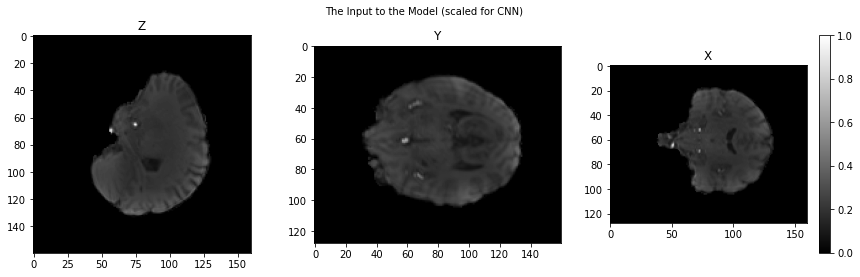

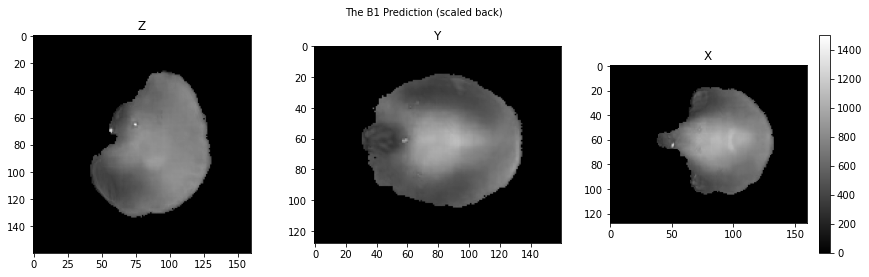

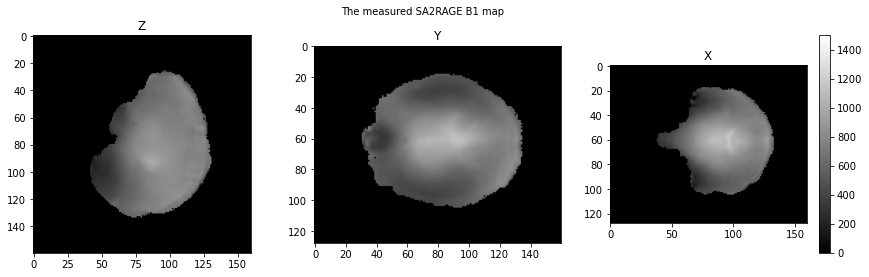

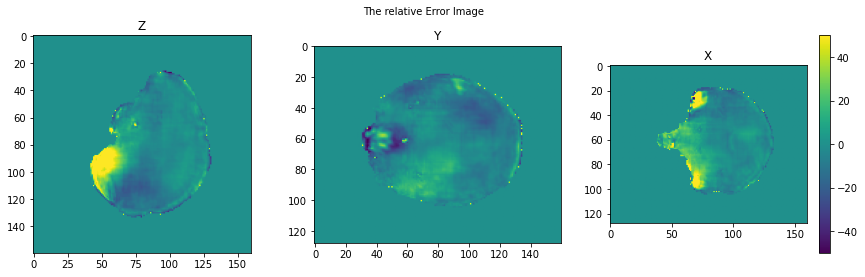

In [35]:
# visulize data
print("Visualizing data predicted using: " + checkpoint_name)

path = PREDICT_FLAGS["input_path"]
img = nib.load(path + PREDICT_FLAGS["scout_name"] + '.nii.gz')
inputImage = img.get_fdata() / PREDICT_FLAGS["train_normalization"]

out_file_name = PREDICT_FLAGS["output_path"] + PREDICT_FLAGS["scout_name"] + '_prediction_' + checkpoint_name + '_DeepFLAIR'
img = nib.load(out_file_name + '.nii')
predImage = img.get_fdata()

img = nib.load(path + PREDICT_FLAGS["B1_name"] + '.nii.gz')
gtImage = img.get_fdata()


predictionErrorAbs = predImage - gtImage
zero_indices = gtImage == 0
gtImage[zero_indices] = 0.000001
predictionErrorPercent = predictionErrorAbs / gtImage * 100

cutOff = 50
super_threshold_indices = predictionErrorPercent > cutOff
supra_threshold_indices = predictionErrorPercent < -cutOff
predictionErrorPercent[super_threshold_indices] = cutOff
predictionErrorPercent[supra_threshold_indices] = -cutOff

mean_squared_error = np.sqrt(np.mean(predictionErrorAbs * predictionErrorAbs))
print('mean squared error total image: ', mean_squared_error)

# slice_nbr = 100
slice_nbr = int(inputImage.shape[1]/2) #centre slice
view_slices_3d(inputImage, slice_nbr=slice_nbr, vmin=0, vmax=1, title='The Input to the Model (scaled for CNN)')
view_slices_3d(predImage, slice_nbr=slice_nbr, vmin=0, vmax=PREDICT_FLAGS['train_normalization'], title='The B1 Prediction (scaled back)')
view_slices_3d(gtImage, slice_nbr=slice_nbr, vmin=0, vmax=PREDICT_FLAGS['train_normalization'], title='The measured SA2RAGE B1 map ')
view_slices_3d(predictionErrorPercent, slice_nbr=slice_nbr, vmin=-50, vmax=50, title='The relative Error Image', cmap='viridis')